# SVM with HOG Features

## Project Overview

This notebook implements and compares multiple SVM models for alphanumeric character classification using HOG (Histogram of Oriented Gradients) features.

### Dataset Characteristics
- **Type**: Alphanumeric character images (A-Z, a-z,)
- **Image Size**: 48x48 grayscale
- **Classes**: 52 classes (26 uppercase + 26 lowercase )
- **Challenge**: High inter-class similarity (e.g., 'O' vs '0', 'I' vs 'l')

### Why SVM with HOG?
1. **HOG Features**: Capture shape and edge information - ideal for character recognition
2. **SVM Strength**: Excellent for high-dimensional data and clear decision boundaries
3. **Efficiency**: Faster training than deep learning for smaller datasets
4. **Robustness**: Less prone to overfitting with proper regularization

### Models Compared in This Notebook
1. **Baseline SVM** (default parameters) - Benchmark
2. **Linear SVM** (tuned C parameter) - For linearly separable features
3. **RBF Kernel SVM** (tuned C and gamma) - For non-linear patterns
4. **Polynomial Kernel SVM** (tuned degree and C) - For polynomial relationships

---

In [1]:
import os
import numpy as np

# Define results directory
RESULTS_PATH = '/home/ubuntu/Desktop/AIML project/results/SVMhog'
os.makedirs(RESULTS_PATH, exist_ok=True)
print(f"Results will be saved to: {RESULTS_PATH}")

Results will be saved to: /home/ubuntu/Desktop/AIML project/results/SVMhog


## Load HOG Features

In [2]:
# Path  HOG features
HOG_FEATURES_PATH = '/home/ubuntu/Desktop/AIML project/results/SVMhog/hog_features'

print("Loading pre-computed 48x48 HOG features...")
train_images_hog = np.load(os.path.join(HOG_FEATURES_PATH, 'train_hog_features_48x48.npy'))
train_labels = np.load(os.path.join(HOG_FEATURES_PATH, 'train_labels_48x48.npy'))

validation_images_hog = np.load(os.path.join(HOG_FEATURES_PATH, 'validation_hog_features_48x48.npy'))
validation_labels = np.load(os.path.join(HOG_FEATURES_PATH, 'validation_labels_48x48.npy'))

test_images_hog = np.load(os.path.join(HOG_FEATURES_PATH, 'test_hog_features_48x48.npy'))
test_labels = np.load(os.path.join(HOG_FEATURES_PATH, 'test_labels_48x48.npy'))

# Print shapes 
print(f"\nTraining data shape (48x48 HOG features): {train_images_hog.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation data shape (48x48 HOG features): {validation_images_hog.shape}")
print(f"Validation labels shape: {validation_labels.shape}")
print(f"Test data shape (48x48 HOG features): {test_images_hog.shape}")
print(f"Test labels shape: {test_labels.shape}")
print("✓ 48x48 HOG features loaded successfully!")

Loading pre-computed 48x48 HOG features...

Training data shape (48x48 HOG features): (13250, 900)
Training labels shape: (13250,)
Validation data shape (48x48 HOG features): (7439, 900)
Validation labels shape: (7439,)
Test data shape (48x48 HOG features): (11423, 900)
Test labels shape: (11423,)
✓ 48x48 HOG features loaded successfully!


## Filter Out Invalid '999' Labels

Remove samples with '999' label  and convert remaining labels to integers.

In [3]:

def convert_labels_to_int(labels):
    int_labels = []
    for label in labels:
        try:
            int_label = int(label)
            if int_label != 999:  
                int_labels.append(int_label)
        except ValueError:
            pass  # Skip if conversion fails
    return np.array(int_labels, dtype=np.int32)

print("Filtering out invalid '999' labels...")

# Find '999' label
train_invalid = [i for i, label in enumerate(train_labels) if label == '999']
val_invalid = [i for i, label in enumerate(validation_labels) if label == '999']
test_invalid = [i for i, label in enumerate(test_labels) if label == '999']

# Remove '999' labels from HOG features and labels
train_images_hog_filtered = np.delete(train_images_hog, train_invalid, axis=0)
train_labels_filtered = np.delete(train_labels, train_invalid, axis=0)

validation_images_hog_filtered = np.delete(validation_images_hog, val_invalid, axis=0)
validation_labels_filtered = np.delete(validation_labels, val_invalid, axis=0)

test_images_hog_filtered = np.delete(test_images_hog, test_invalid, axis=0)
test_labels_filtered = np.delete(test_labels, test_invalid, axis=0)

# Convert labels to integers
train_labels_int = convert_labels_to_int(train_labels_filtered)
validation_labels_int = convert_labels_to_int(validation_labels_filtered)
test_labels_int = convert_labels_to_int(test_labels_filtered)

# Display results
print(f"\n✓ Filtering complete!")
print(f"Training:   {train_images_hog_filtered.shape[0]} samples")
print(f"Validation: {validation_images_hog_filtered.shape[0]} samples")
print(f"Test:       {test_images_hog_filtered.shape[0]} samples")


Filtering out invalid '999' labels...

✓ Filtering complete!
Training:   13000 samples
Validation: 7189 samples
Test:       11173 samples


## Train Baseline SVM Model

In [4]:
from sklearn.svm import SVC
import time

baseline_svm_model = SVC()

print("Training baseline SVM model (default parameters)...")
start_time = time.time()
baseline_svm_model.fit(train_images_hog_filtered, train_labels_int)
baseline_training_time = time.time() - start_time
print(f"✓ Baseline training complete in {baseline_training_time:.2f} seconds")

baseline_test_accuracy = baseline_svm_model.score(test_images_hog_filtered, test_labels_int)
print(f"Baseline Test Accuracy: {baseline_test_accuracy:.4f} ({baseline_test_accuracy*100:.2f}%)")

baseline_validation_accuracy = baseline_svm_model.score(validation_images_hog_filtered, validation_labels_int)
print(f"Baseline Validation Accuracy: {baseline_validation_accuracy:.4f} ({baseline_validation_accuracy*100:.2f}%)")

Training baseline SVM model (default parameters)...
✓ Baseline training complete in 13.71 seconds
Baseline Test Accuracy: 0.8455 (84.55%)
Baseline Validation Accuracy: 0.8430 (84.30%)



## Hyperparameter Tuning and  Cross-Validation

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time

# Define parameters to test
param_grid = {
    'C': [0.1, 1, 10, 100],              
    'kernel': ['linear', 'rbf', 'poly'],  
    'gamma': ['scale', 'auto'],           # non-linear
    'degree': [2, 3]                      # Pol
}

# Create GridSearchCV
grid_search_hog = GridSearchCV(
    SVC(),                  
    param_grid,             
    cv=3,                  
    scoring='accuracy',     #  acc check 
    verbose=2,              # Show progress
    n_jobs=-1               
)

print("=" * 80)
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("=" * 80)
print(f"\nParameters to test:")
print(f"  • C (Regularization): {param_grid['C']}")
print(f"  • Kernels: {param_grid['kernel']}")
print(f"  • Gamma: {param_grid['gamma']}")
print(f"  • Polynomial degrees: {param_grid['degree']}")
print(f"\nTotal combinations: {len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma']) * len(param_grid['degree'])}")
print(f"Cross-validation: {grid_search_hog.cv}-fold")
print("=" * 80)


# Find best parameters
print("\nStarting hyperparameter search...")
grid_start = time.time()
grid_search_hog.fit(train_images_hog_filtered, train_labels_int)
grid_time = time.time() - grid_start

print(f"\n✓ Search complete in {grid_time:.2f} seconds")
print(f"Best score: {grid_search_hog.best_score_:.4f}")
print(f"Best parameters: {grid_search_hog.best_params_}")


HYPERPARAMETER TUNING WITH GRIDSEARCHCV

Parameters to test:
  • C (Regularization): [0.1, 1, 10, 100]
  • Kernels: ['linear', 'rbf', 'poly']
  • Gamma: ['scale', 'auto']
  • Polynomial degrees: [2, 3]

Total combinations: 48
Cross-validation: 3-fold

Starting hyperparameter search...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time= 1.0min
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time= 1.1min
[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time= 1.1min
[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time= 1.2min
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time= 1.2min
[CV] END .........C=0.1, degree=2, gamma=auto, kernel=linear; total time= 1.2min
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time= 1.4min
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time= 1.5min
[CV]

In [6]:
# show best para
best_params_hog = grid_search_hog.best_params_

print("Best hyperparameters found:")
print(best_params_hog)

Best hyperparameters found:
{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


## Train Multiple SVM Models for Comparison

Now we'll train individual models with different kernels to compare their performance characteristics.

In [15]:
import time

# Store results for all models
models_results = []

print("\n" + "=" * 80)
print("TRAINING MULTIPLE SVM MODELS")
print("=" * 80 + "\n")

# Model 1: Linear SVM
print("1 Training Linear SVM (best for linearly separable data)...")
linear_svm = SVC(kernel='linear', C=best_params_hog['C'])
start = time.time()
linear_svm.fit(train_images_hog_filtered, train_labels_int)
train_time = time.time() - start

# Evaluate Linear SVM
linear_test_acc = linear_svm.score(test_images_hog_filtered, test_labels_int)
linear_val_acc = linear_svm.score(validation_images_hog_filtered, validation_labels_int)

models_results.append({
    'name': 'Linear SVM',
    'model': linear_svm,
    'params': {'kernel': 'linear', 'C': 10},
    'train_time': train_time,
    'test_acc': linear_test_acc,
    'val_acc': linear_val_acc
})
print(f"   ✓ Test: {linear_test_acc*100:.2f}% | Val: {linear_val_acc*100:.2f}% | Time: {train_time:.2f}s\n")

#  Model 2: RBF Kernel SVM 
print("2 Training RBF Kernel SVM (best for non-linear patterns)...")
rbf_svm = SVC(kernel=best_params_hog['kernel'], C=best_params_hog['C'], gamma=best_params_hog['gamma'])
start = time.time()
rbf_svm.fit(train_images_hog_filtered, train_labels_int)
train_time = time.time() - start

# Evaluate RBF SVM
rbf_test_acc = rbf_svm.score(test_images_hog_filtered, test_labels_int)
rbf_val_acc = rbf_svm.score(validation_images_hog_filtered, validation_labels_int)

models_results.append({
    'name': 'RBF Kernel SVM',
    'model': rbf_svm,
    'params': {'kernel': best_params_hog['kernel'], 'C': best_params_hog['C'], 'gamma': best_params_hog['gamma']},
    'train_time': train_time,
    'test_acc': rbf_test_acc,
    'val_acc': rbf_val_acc
})
print(f"   ✓ Test: {rbf_test_acc*100:.2f}% | Val: {rbf_val_acc*100:.2f}% | Time: {train_time:.2f}s\n")

# Model 3: Polynomial Kernel SVM
print("3 Training Polynomial Kernel SVM (for polynomial relationships)...")
poly_svm = SVC(kernel='poly', C=10, degree=3, gamma='scale')
start = time.time()
poly_svm.fit(train_images_hog_filtered, train_labels_int)
train_time = time.time() - start

# Evaluate Polynomial SVM
poly_test_acc = poly_svm.score(test_images_hog_filtered, test_labels_int)
poly_val_acc = poly_svm.score(validation_images_hog_filtered, validation_labels_int)

models_results.append({
    'name': f"Polynomial SVM (deg={best_params_hog['degree']})",
    'model': poly_svm,
    'params': {'kernel': 'poly', 'C': best_params_hog['C'], 'degree': best_params_hog['degree'], 'gamma': 'scale'},
    'train_time': train_time,
    'test_acc': poly_test_acc,
    'val_acc': poly_val_acc
})
print(f"   ✓ Test: {poly_test_acc*100:.2f}% | Val: {poly_val_acc*100:.2f}% | Time: {train_time:.2f}s\n")

#  Add Baseline to results
models_results.insert(0, {
    'name': 'Baseline SVM',
    'model': baseline_svm_model,
    'params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    'train_time': baseline_training_time,
    'test_acc': baseline_test_accuracy,
    'val_acc': baseline_validation_accuracy
})

print("=" * 80)
print("✓ ALL MODELS TRAINED SUCCESSFULLY")
print("=" * 80)



TRAINING MULTIPLE SVM MODELS

1 Training Linear SVM (best for linearly separable data)...
   ✓ Test: 82.33% | Val: 82.36% | Time: 6.66s

2 Training RBF Kernel SVM (best for non-linear patterns)...
   ✓ Test: 85.47% | Val: 85.45% | Time: 13.63s

3 Training Polynomial Kernel SVM (for polynomial relationships)...
   ✓ Test: 85.42% | Val: 85.31% | Time: 10.96s

✓ ALL MODELS TRAINED SUCCESSFULLY


## Comprehensive Model Comparison

Compare all trained models across multiple metrics to identify the best performer.

In [16]:
import pandas as pd

# Create comparison table
comparison_data = []
for result in models_results:
    comparison_data.append({
        'Model': result['name'],
        'Kernel': result['params']['kernel'],
        'Test Acc (%)': f"{result['test_acc']*100:.2f}",
        'Val Acc (%)': f"{result['val_acc']*100:.2f}",
        'Time (s)': f"{result['train_time']:.2f}",
        'Parameters': str(result['params'])
    })

comparison_df = pd.DataFrame(comparison_data)

# Display  table
print("\n" + "=" * 100)
print("MODEL COMPARISON TABLE")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Find best model
best_idx = max(range(len(models_results)), key=lambda i: models_results[i]['test_acc'])
best = models_results[best_idx]

print(f"\n BEST MODEL: {best['name']}")
print(f"   Test Accuracy: {best['test_acc']*100:.2f}%")
print(f"   Val Accuracy:  {best['val_acc']*100:.2f}%")
print(f"   Training Time: {best['train_time']:.2f}s")

# Save table
csv_path = os.path.join(RESULTS_PATH, 'model_comparison_table.csv')
comparison_df.to_csv(csv_path, index=False)
print(f"\n✓ Table saved to: {csv_path}")



MODEL COMPARISON TABLE
                 Model Kernel Test Acc (%) Val Acc (%) Time (s)                                                 Parameters
          Baseline SVM    rbf        84.55       84.30    13.71              {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}
            Linear SVM linear        82.33       82.36     6.66                              {'kernel': 'linear', 'C': 10}
        RBF Kernel SVM    rbf        85.47       85.45    13.63               {'kernel': 'rbf', 'C': 10, 'gamma': 'scale'}
Polynomial SVM (deg=2)   poly        85.42       85.31    10.96 {'kernel': 'poly', 'C': 10, 'degree': 2, 'gamma': 'scale'}

 BEST MODEL: RBF Kernel SVM
   Test Accuracy: 85.47%
   Val Accuracy:  85.45%
   Training Time: 13.63s

✓ Table saved to: /home/ubuntu/Desktop/AIML project/results/SVMhog/model_comparison_table.csv


## Visualize All Models Performance

Create comprehensive visualization comparing all models.

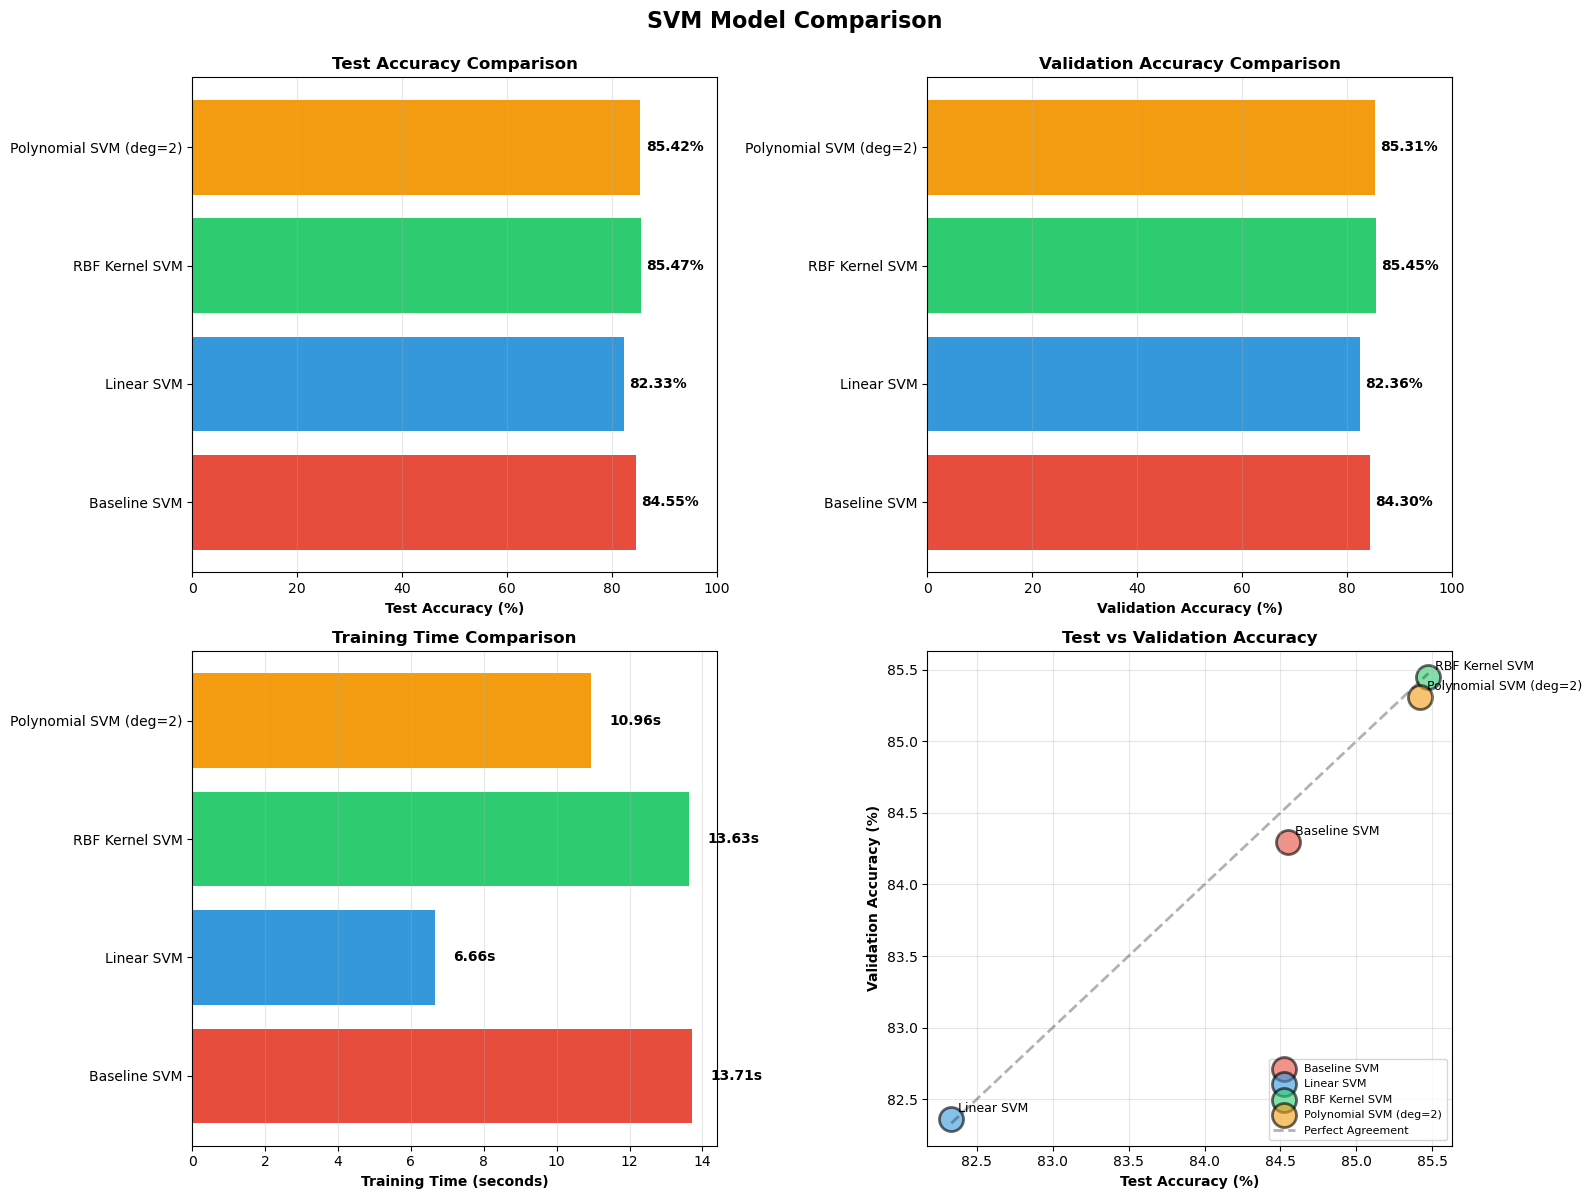

✓ Chart saved to: /home/ubuntu/Desktop/AIML project/results/SVMhog/all_models_comparison.png


In [17]:
import matplotlib.pyplot as plt

# Extract data for visualization
model_names = [r['name'] for r in models_results]
test_accs = [r['test_acc'] * 100 for r in models_results]
val_accs = [r['val_acc'] * 100 for r in models_results]
train_times = [r['train_time'] for r in models_results]
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SVM Model Comparison', fontsize=16, fontweight='bold', y=0.995)

# 1. Test Accuracy
ax1 = axes[0, 0]
bars = ax1.barh(model_names, test_accs, color=colors)
ax1.set_xlabel('Test Accuracy (%)', fontweight='bold')
ax1.set_title('Test Accuracy Comparison', fontweight='bold')
ax1.set_xlim([0, 100])
for i, bar in enumerate(bars):
    ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'{test_accs[i]:.2f}%', va='center', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Validation Accuracy
ax2 = axes[0, 1]
bars = ax2.barh(model_names, val_accs, color=colors)
ax2.set_xlabel('Validation Accuracy (%)', fontweight='bold')
ax2.set_title('Validation Accuracy Comparison', fontweight='bold')
ax2.set_xlim([0, 100])
for i, bar in enumerate(bars):
    ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'{val_accs[i]:.2f}%', va='center', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Training Time
ax3 = axes[1, 0]
bars = ax3.barh(model_names, train_times, color=colors)
ax3.set_xlabel('Training Time (seconds)', fontweight='bold')
ax3.set_title('Training Time Comparison', fontweight='bold')
for i, bar in enumerate(bars):
    ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{train_times[i]:.2f}s', va='center', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Test vs Validation Accuracy Scatter
ax4 = axes[1, 1]
for i, result in enumerate(models_results):
    ax4.scatter(result['test_acc']*100, result['val_acc']*100, 
               s=300, alpha=0.6, color=colors[i], 
               edgecolors='black', linewidth=2, label=result['name'])
    ax4.annotate(result['name'], 
                xy=(result['test_acc']*100, result['val_acc']*100),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add diagonal line (perfect agreement)
min_acc = min(min(test_accs), min(val_accs))
max_acc = max(max(test_accs), max(val_accs))
ax4.plot([min_acc, max_acc], [min_acc, max_acc], 'k--', 
         alpha=0.3, linewidth=2, label='Perfect Agreement')

ax4.set_xlabel('Test Accuracy (%)', fontweight='bold')
ax4.set_ylabel('Validation Accuracy (%)', fontweight='bold')
ax4.set_title('Test vs Validation Accuracy', fontweight='bold')
ax4.legend(fontsize=8, loc='lower right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
chart_path = os.path.join(RESULTS_PATH, 'all_models_comparison.png')
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Chart saved to: {chart_path}")


## Best model accuracy in  hyperparameter tuning 

In [18]:
# Use the best model from GridSearchCV
tuned_svm_model_hog = grid_search_hog.best_estimator_

print("=" * 80)
print("FINAL MODEL SELECTION - BEST FROM GRIDSEARCHCV")
print("=" * 80)
print(f"Best Parameters: {grid_search_hog.best_params_}")
print(f"Cross-Validation Score: {grid_search_hog.best_score_:.4f}")
print("=" * 80 + "\n")

# Evaluate on all datasets
test_accuracy_hog = tuned_svm_model_hog.score(test_images_hog_filtered, test_labels_int)
validation_accuracy_hog = tuned_svm_model_hog.score(validation_images_hog_filtered, validation_labels_int)
train_accuracy_hog = tuned_svm_model_hog.score(train_images_hog_filtered, train_labels_int)

# Print results
print("FINAL MODEL PERFORMANCE")
print("=" * 80)
print(f"Training Accuracy:   {train_accuracy_hog:.4f} ({train_accuracy_hog*100:.2f}%)")
print(f"Validation Accuracy: {validation_accuracy_hog:.4f} ({validation_accuracy_hog*100:.2f}%)")
print(f"Test Accuracy:       {test_accuracy_hog:.4f} ({test_accuracy_hog*100:.2f}%)")
print("=" * 80)

# Check for overfitting
gap = train_accuracy_hog - test_accuracy_hog
if gap > 0.05:
    print(f"\n  Warning: Overfitting detected (train-test gap = {gap*100:.2f}%)")
else:
    print(f"\n✓ Good generalization (train-test gap = {gap*100:.2f}%)")


FINAL MODEL SELECTION - BEST FROM GRIDSEARCHCV
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Cross-Validation Score: 0.7810

FINAL MODEL PERFORMANCE
Training Accuracy:   0.9998 (99.98%)
Validation Accuracy: 0.8545 (85.45%)
Test Accuracy:       0.8547 (85.47%)



## Confusion Matrix

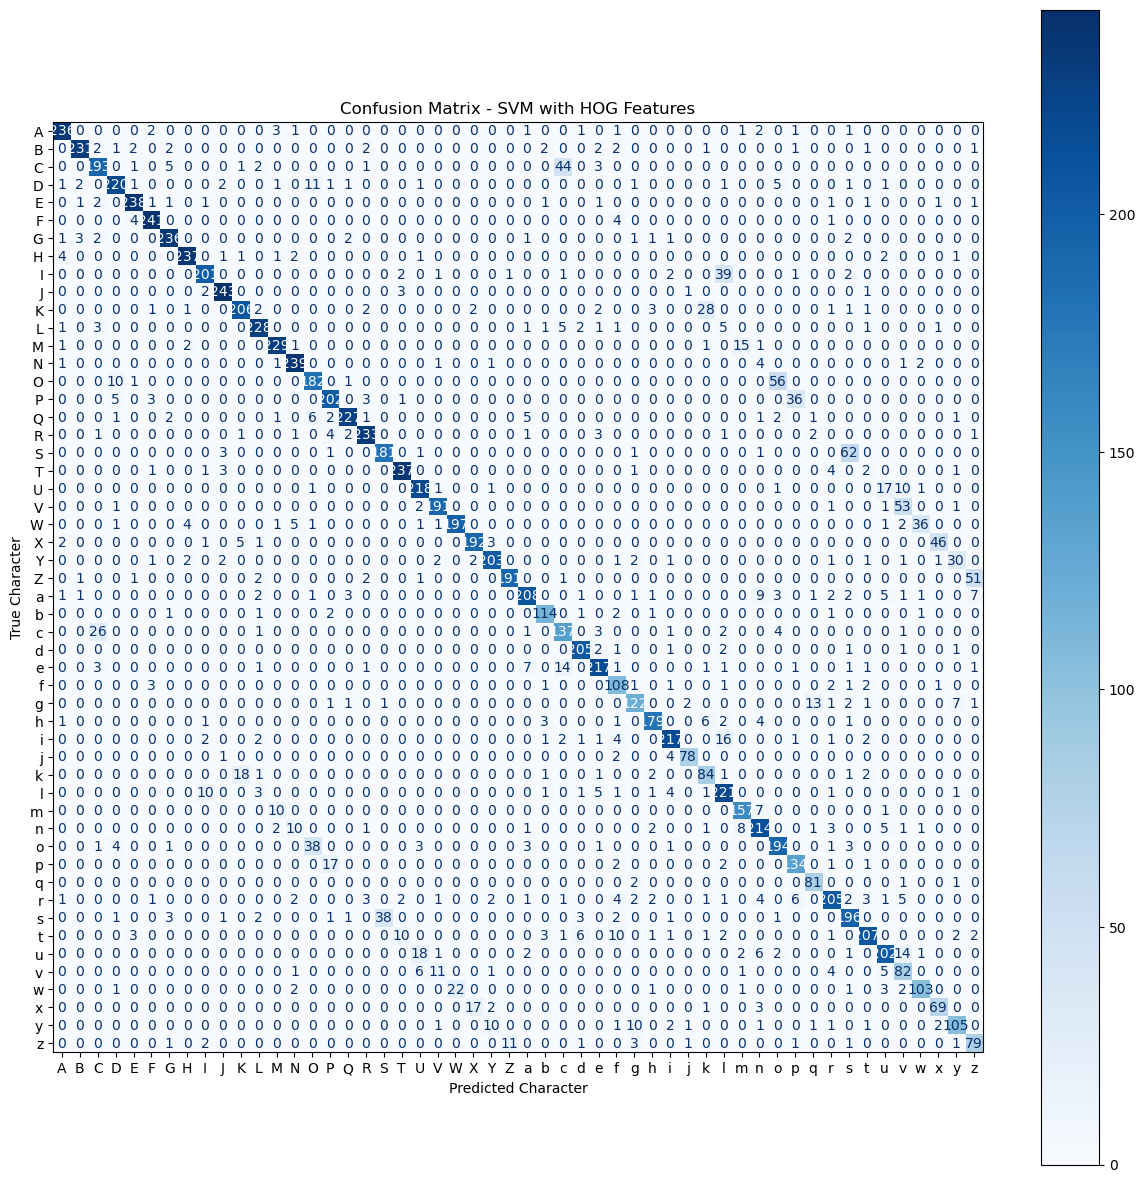

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on test data
test_predictions_hog_int = tuned_svm_model_hog.predict(test_images_hog_filtered)

# Compute confusion matrix
cm_hog = confusion_matrix(test_labels_int, test_predictions_hog_int)

# Convert label numbers to characters for display
unique_labels_int = np.unique(test_labels_int)
unique_labels_char = [chr(label) for label in unique_labels_int]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hog, display_labels=unique_labels_char)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix - SVM with HOG Features')
plt.xlabel('Predicted Character')
plt.ylabel('True Character')
plt.show()

## Validation Accuracy


In [20]:
# Evaluate on validation data
validation_accuracy_hog = tuned_svm_model_hog.score(validation_images_hog_filtered, validation_labels_int)

print(f"Validation Accuracy: {validation_accuracy_hog:.4f} ({validation_accuracy_hog*100:.2f}%)")

Validation Accuracy: 0.8545 (85.45%)


## Save Model and Results

In [21]:
import joblib

# Define file paths for 48x48 model
model_path_hog = os.path.join(RESULTS_PATH, 'tuned_svm_model_hog_48x48.joblib')
accuracy_path_hog = os.path.join(RESULTS_PATH, 'test_accuracy_hog_48x48.txt')

# Save the trained model
joblib.dump(tuned_svm_model_hog, model_path_hog)
print(f"✓ Model saved to: {model_path_hog}")

# Save the test accuracy
with open(accuracy_path_hog, 'w') as f:
    f.write(f"{test_accuracy_hog:.4f}")
print(f"✓ Test accuracy saved to: {accuracy_path_hog}")

print(f"\n Model trained on 48x48 images with HOG features")
print(f" Testing medium-small resolution for optimal balance")

✓ Model saved to: /home/ubuntu/Desktop/AIML project/results/SVMhog/tuned_svm_model_hog_48x48.joblib
✓ Test accuracy saved to: /home/ubuntu/Desktop/AIML project/results/SVMhog/test_accuracy_hog_48x48.txt

 Model trained on 48x48 images with HOG features
 Testing medium-small resolution for optimal balance


## Compare Baseline vs  Hyperparameter Tuning 


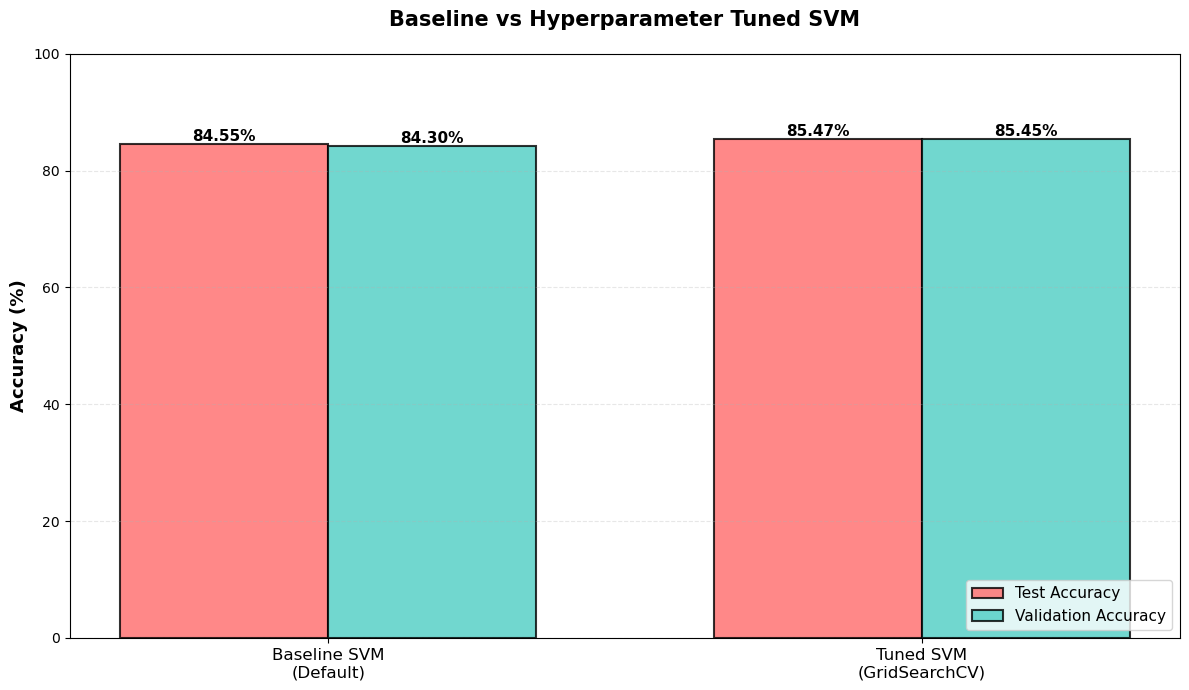


BASELINE VS TUNED COMPARISON

Baseline SVM:
  Test:       84.55%
  Validation: 84.30%

Tuned SVM ({'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}):
  Test:       85.47%
  Validation: 85.45%

Improvement:
  Test:       +0.92%
  Validation: +1.15%

✓ Chart saved to: /home/ubuntu/Desktop/AIML project/results/SVMhog/baseline_vs_tuned_comparison.png


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
models = ['Baseline SVM\n(Default)', 'Tuned SVM\n(GridSearchCV)']
test_accs = [baseline_test_accuracy * 100, test_accuracy_hog * 100]
val_accs = [baseline_validation_accuracy * 100, validation_accuracy_hog * 100]

x = np.arange(len(models))
width = 0.35

# Create chart
fig, ax = plt.subplots(figsize=(12, 7))

# Create bars
bars1 = ax.bar(x - width/2, test_accs, width, label='Test Accuracy', 
               color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, val_accs, width, label='Validation Accuracy', 
               color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')

add_labels(bars1)
add_labels(bars2)

# Customize
ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('Baseline vs Hyperparameter Tuned SVM', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=11, loc='lower right')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
chart_path = os.path.join(RESULTS_PATH, 'baseline_vs_tuned_comparison.png')
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
plt.show()

# Print comparison summary
print("\n" + "="*80)
print("BASELINE VS TUNED COMPARISON")
print("="*80)
print(f"\nBaseline SVM:")
print(f"  Test:       {baseline_test_accuracy*100:.2f}%")
print(f"  Validation: {baseline_validation_accuracy*100:.2f}%")

print(f"\nTuned SVM ({best_params_hog}):")
print(f"  Test:       {test_accuracy_hog*100:.2f}%")
print(f"  Validation: {validation_accuracy_hog*100:.2f}%")

print(f"\nImprovement:")
test_imp = (test_accuracy_hog - baseline_test_accuracy) * 100
val_imp = (validation_accuracy_hog - baseline_validation_accuracy) * 100
print(f"  Test:       +{test_imp:.2f}%")
print(f"  Validation: +{val_imp:.2f}%")
print("="*80)

print(f"\n✓ Chart saved to: {chart_path}")
